# Проект: Выбор локации для скважины

<b>Описание проекта</b>
<p>
Компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину. Известны качество нефти и объём её запасов для каждой скважины в регионе. Нам предоставлены пробы нефти в трёх регионах, нужно выбрать оптимальный регион.
</p>

**Цель:** выбрать регион, где добыча нефти принесет максимальную суммарную прибыль

<b>Задачи:</b>
<ol>
<li>Первая —  построить модель для определения региона, где добыча нефти принесёт наибольшую прибыль.</li>
<li>Проанализировать возможную прибыль и риски.</li>
</ol>

## Подключение необходимых библиотек

In [1]:
!pip install scikit-learn==1.4 -q
!pip install pandas==1.5.0 -q

import pandas as pd
import os
import platform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats as st

# загружаем классы для подготовки данных
from sklearn.preprocessing import MinMaxScaler

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from numpy.random import RandomState

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

  You can safely remove it manually.


<b>Исходные данные:</b> данные о сотрудниках компании, предоставленные заказчиком (тренировочная выборка, тестовая выборка, целевой признак тестовой выборки)

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

## 1.1 Загрузка данных

Прочитаем исходные данные из файлов

In [2]:
datasets_path='/datasets/'
if platform.system()=='Windows':
    cwd = os.getcwd()
    datasets_path= os.getcwd()+'\\datasets\\'
geo_data_0= pd.read_csv(datasets_path+'geo_data_0.csv', sep=',')
geo_data_1= pd.read_csv(datasets_path+'geo_data_1.csv', sep=',')
geo_data_2= pd.read_csv(datasets_path+'geo_data_2.csv', sep=',')

##  1.2 Предобработка данных

Выведем общую информацию и первые 5 строк файла geo_data_0.csv для контроля загрузки и первого знакомства с данными

In [3]:
data=[geo_data_0, geo_data_1, geo_data_2]
for i in range(0,3):
    print('\nДанные по региону ', i+1)
    print(data[i].info())
    print(data[i].head())


Данные по региону  1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

Данные по региону  2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non

**Вывод: пропуски в данных не обнаружены.**

#### Поиск явных дубликатов

In [4]:
for i in range(0,3):
    print(f'Количество полных дубликатов в {i+1} регионе: {data[i].duplicated().sum()}')

Количество полных дубликатов в 1 регионе: 0
Количество полных дубликатов в 2 регионе: 0
Количество полных дубликатов в 3 регионе: 0


**Вывод: явные дубликаты не найдены**

#### Удаление неявных дубликатов

Для каждой из возможных точек бурения скважим нам нужен 1 набор характеристик, поэтому требуется удалить дублирующие данные для имеюих одинаковый id точек

In [5]:
data=[geo_data_0, geo_data_1, geo_data_2]
for i in range(0,3):
    print(f'Исходное количество записей для {i+1} региона: {len(data[i])}')
    data[i]= data[i].drop_duplicates(subset='id')
    print(f'Количество записей для {i+1} региона без дубликатов по id: {len(data[i])}')

Исходное количество записей для 1 региона: 100000
Количество записей для 1 региона без дубликатов по id: 99990
Исходное количество записей для 2 региона: 100000
Количество записей для 2 региона без дубликатов по id: 99996
Исходное количество записей для 3 региона: 100000
Количество записей для 3 региона без дубликатов по id: 99996


#### Изучим числовые характеристики исходных данных 

In [6]:
for i in range(0,3):
    print(f'Числовые характеристики данных {i+1} региона')
    print(data[i].describe())

Числовые характеристики данных 1 региона
                 f0            f1            f2       product
count  99990.000000  99990.000000  99990.000000  99990.000000
mean       0.500454      0.250141      2.502629     92.499684
std        0.871844      0.504430      3.248149     44.288304
min       -1.408605     -0.848218    -12.088328      0.000000
25%       -0.072572     -0.200877      0.287784     56.497069
50%        0.502405      0.250252      2.515969     91.847928
75%        1.073626      0.700640      4.715035    128.563699
max        2.362331      1.343769     16.003790    185.364347
Числовые характеристики данных 2 региона
                 f0            f1            f2       product
count  99996.000000  99996.000000  99996.000000  99996.000000
mean       1.141209     -4.796608      2.494501     68.823916
std        8.965815      5.119906      1.703579     45.944663
min      -31.609576    -26.358598     -0.018144      0.000000
25%       -6.298551     -8.267985      1.000021   

**Анализ распределения значений исходных данных и целевого признака**

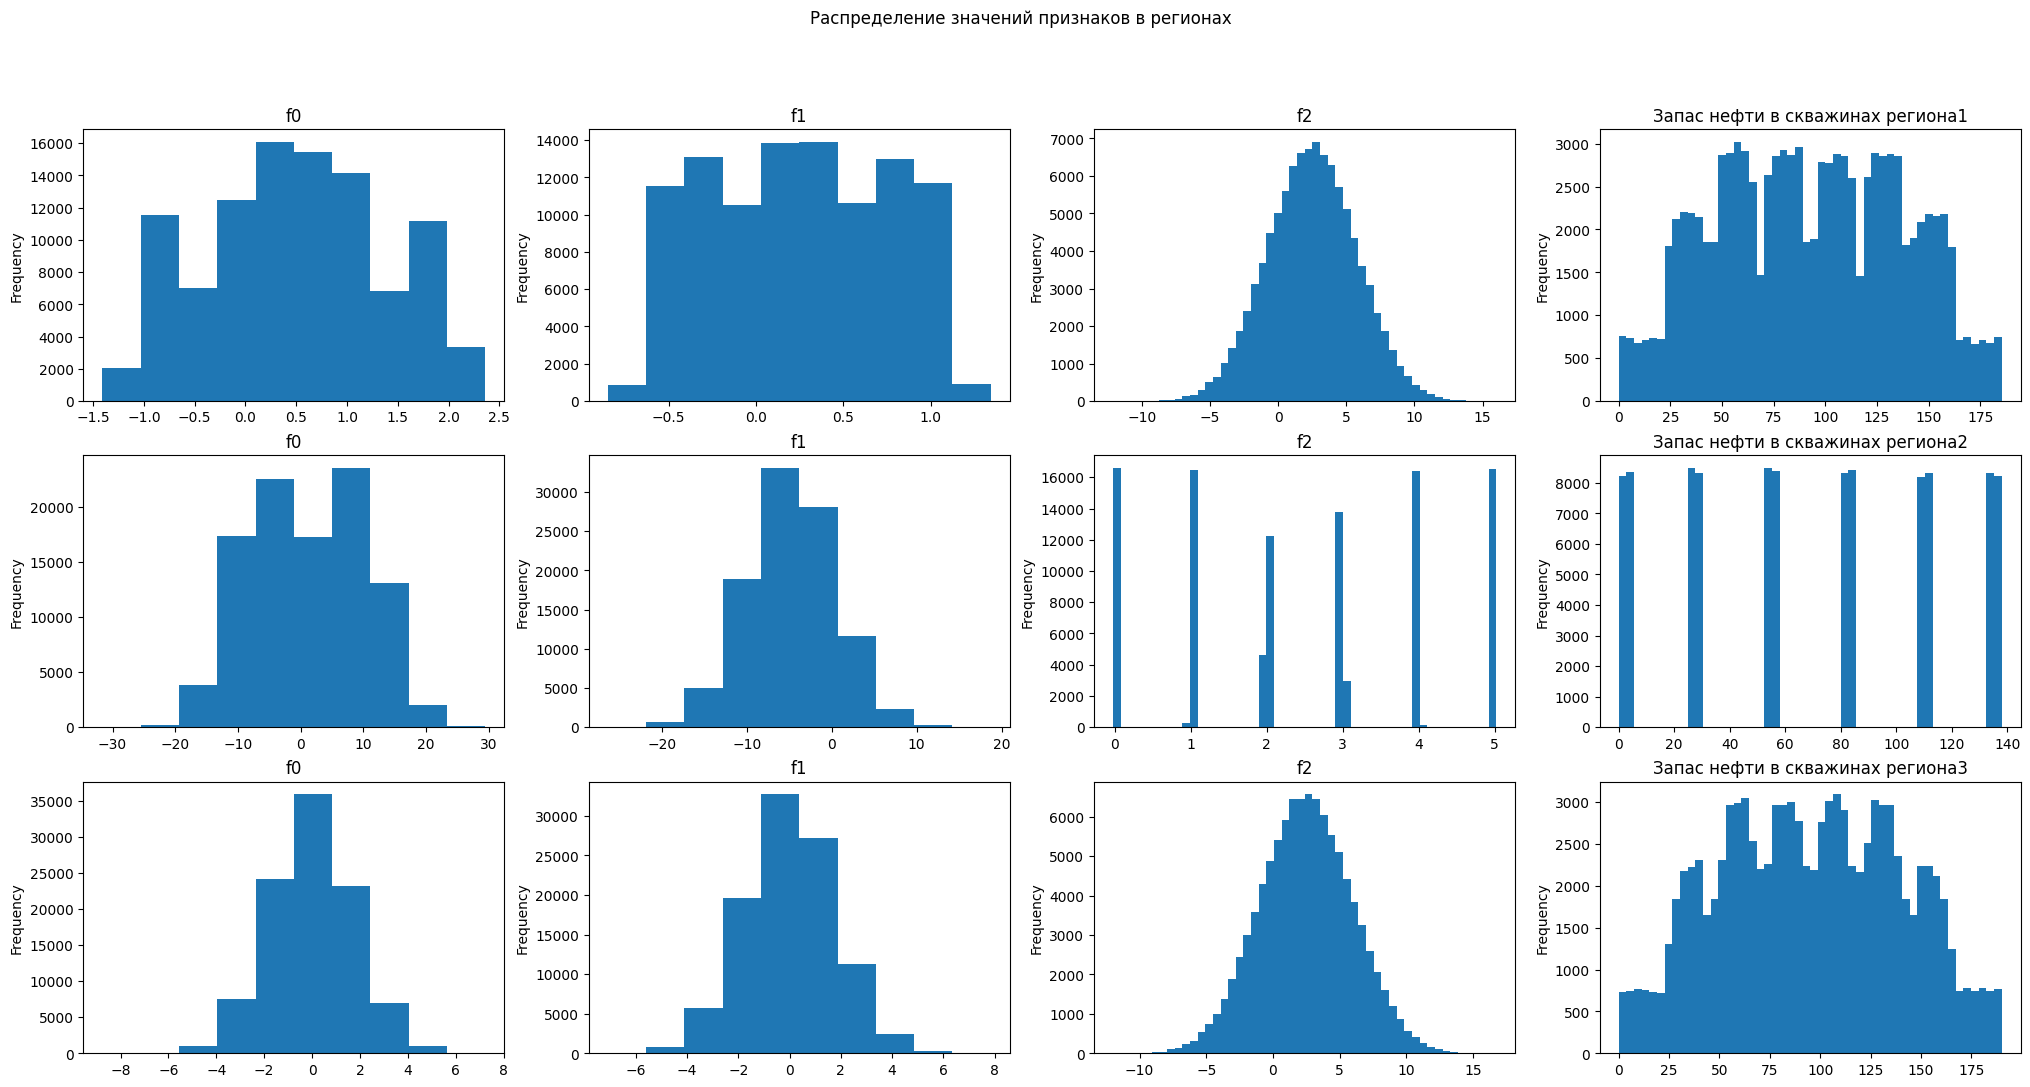

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25,12))
fig.suptitle(f'Распределение значений признаков в регионах')
for i, df in zip(range(0,3),data):
    df['f0'].plot(
    ax=axes[i,0],
    kind='hist',
    title='f0')
    df['f1'].plot(
    ax=axes[i,1],
    kind='hist',
    title='f1')
    df['f2'].plot(
    ax=axes[i,2],
    kind='hist',
    bins=50,
    title='f2')
    df['product'].plot(
    ax=axes[i,3],
    bins=50,
    kind='hist',
    title='Запас нефти в скважинах региона'+str(i+1))
plt.show()

Построим матрицу корреляции Спирамана для каждого региона чтобы проверить наличие мультиколлинеарности и влияние на целевой признак

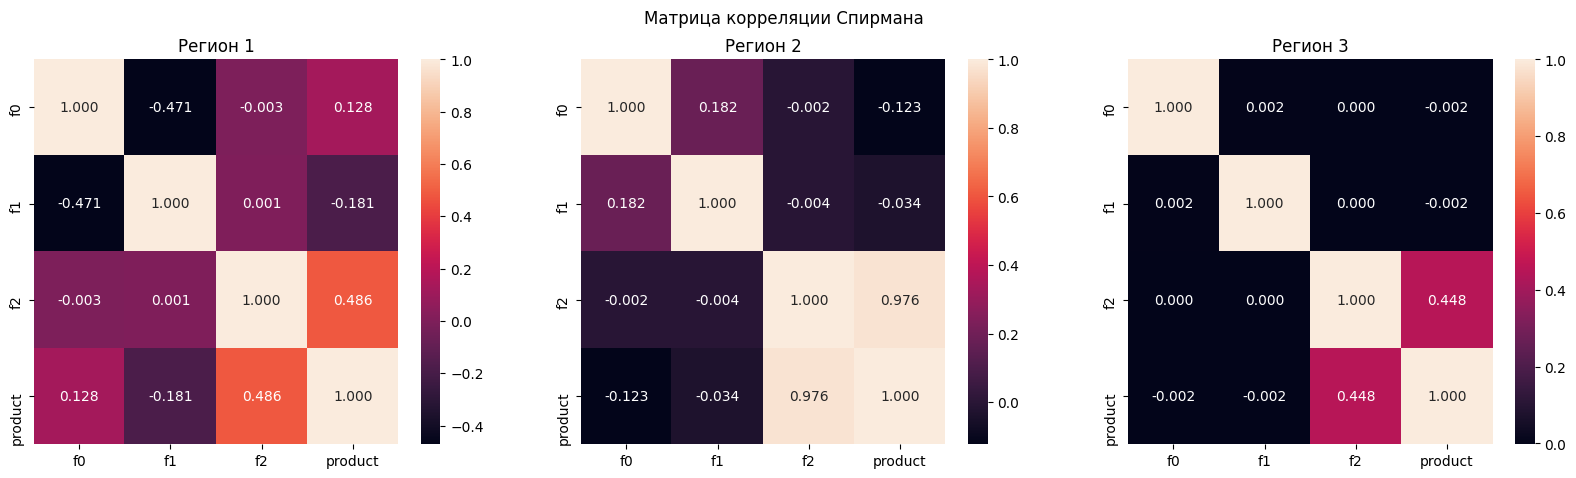

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle(f'Матрица корреляции Спирмана')
for i in range(0,3):
    df= data[i].drop(columns=['id'], axis=1)
    #матрица корреляции Спирмана
    sns.heatmap(
        df.corr(method='spearman'), 
        ax= axes[i], 
        annot=True, 
        fmt='.3f'
    ) 
    axes[i].set_title('Регион '+str(i+1))
plt.show()

**Вывод: значения исходных признаков имеют разный масштаб, поэтому требуется масштабирование, чтобы один из признаков не "перетянул одеяло на себя" при моделировании. Признаков мультиколлинеарности нет. Во втором регионе, признаки f2 и product имеет дискретные (хотя и не целые) значения, хотя данные признаки ожидаются, как непрерывные величины. Можно предположить, что при разведке скважин второго региона, у оборудования были определенные ограничения, которые и дали эти значения.**

##  2 Обучение модели

Напишем функцию разделения признаков на исходные и целевые

In [9]:
# объявляем константу random_state
RANDOM_STATE = 77

#массив датафреймов с данными по реальным и предсказанным значениям
y_valid_pred_arr=[]

def split_features_and_target(i):
    X = data[i].drop(columns=['id', 'product'], axis=1)
    y = data[i]['product']
    return X, y

Делим данные на тренировочные и валидационные, масштабируем исходные признаки тк данные не сбалансированы

In [10]:
def prepair(i):
    print('\nРегион:', i+1)
    X, y= split_features_and_target(i)
    # делим данные на тренировочные и валидационные
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    print(f'Размер датасета исходных признаков тренировочных данных: {X_train.shape}')
    print(f'Размер датасета целевых признаков тренировочных данных: {y_train.shape}')
    print(f'Размер датасета исходных признаков валидационных данных: {X_valid.shape}')
    print(f'Размер датасета целевых признаков валидационных данных: {y_valid.shape}')
    
    scaler = MinMaxScaler()

    # передадим признаки в тренировочную выборку и масштабируем их
    X_train_scalled = scaler.fit_transform(X_train)
    X_valid_scalled = scaler.transform(X_valid)
    return X_train_scalled, y_train, X_valid_scalled, y_valid

Обучаем модель и предсказываем запас сырья для каждого из возможных мест бурения, считаем средний запас для региона и метрику модели для каждого региона

In [11]:
def prepair_and_predict(i):
    X_train_scalled, y_train, X_valid_scalled, y_valid= prepair(i)
    # инициализируем модель линейной регрессии
    model = LinearRegression()
    # обучим модель
    model.fit(X_train_scalled, y_train)
    y_pred = model.predict(X_valid_scalled)

    print(f'Средний запас предсказанного сырья для региона {i+1}: {round(y_pred.mean(),2)} тыс.баррелей')
    RMSE = root_mean_squared_error(y_valid.tolist(), y_pred) 
    print(f'RMSE: {round(RMSE,2)}')
    return y_valid, y_pred

Выполняем моделирование и расчет показателей для каждого региона

In [12]:
for i in range(0,3):
    y_valid, y_pred= prepair_and_predict(i)
    df= pd.DataFrame(data=np.column_stack([y_valid, y_pred]), index= y_valid.index.copy(), columns= ['y_true', 'y_pred'])
    print('Датасет с известными/предсказанными значениями:')
    print(df.head())
    print(f'Размер датасета: {df.shape}')
    y_valid_pred_arr.append(df)


Регион: 1
Размер датасета исходных признаков тренировочных данных: (74992, 3)
Размер датасета целевых признаков тренировочных данных: (74992,)
Размер датасета исходных признаков валидационных данных: (24998, 3)
Размер датасета целевых признаков валидационных данных: (24998,)
Средний запас предсказанного сырья для региона 1: 92.37 тыс.баррелей
RMSE: 37.73
Датасет с известными/предсказанными значениями:
           y_true     y_pred
25936   47.520816  76.580576
72047   58.662072  71.534412
59688   62.388876  64.237336
41145   39.155891  93.452282
18626  107.241639  61.730095
Размер датасета: (24998, 2)

Регион: 2
Размер датасета исходных признаков тренировочных данных: (74997, 3)
Размер датасета целевых признаков тренировочных данных: (74997,)
Размер датасета исходных признаков валидационных данных: (24999, 3)
Размер датасета целевых признаков валидационных данных: (24999,)
Средний запас предсказанного сырья для региона 2: 68.93 тыс.баррелей
RMSE: 0.89
Датасет с известными/предсказанными

**Анализ остатков моделей**

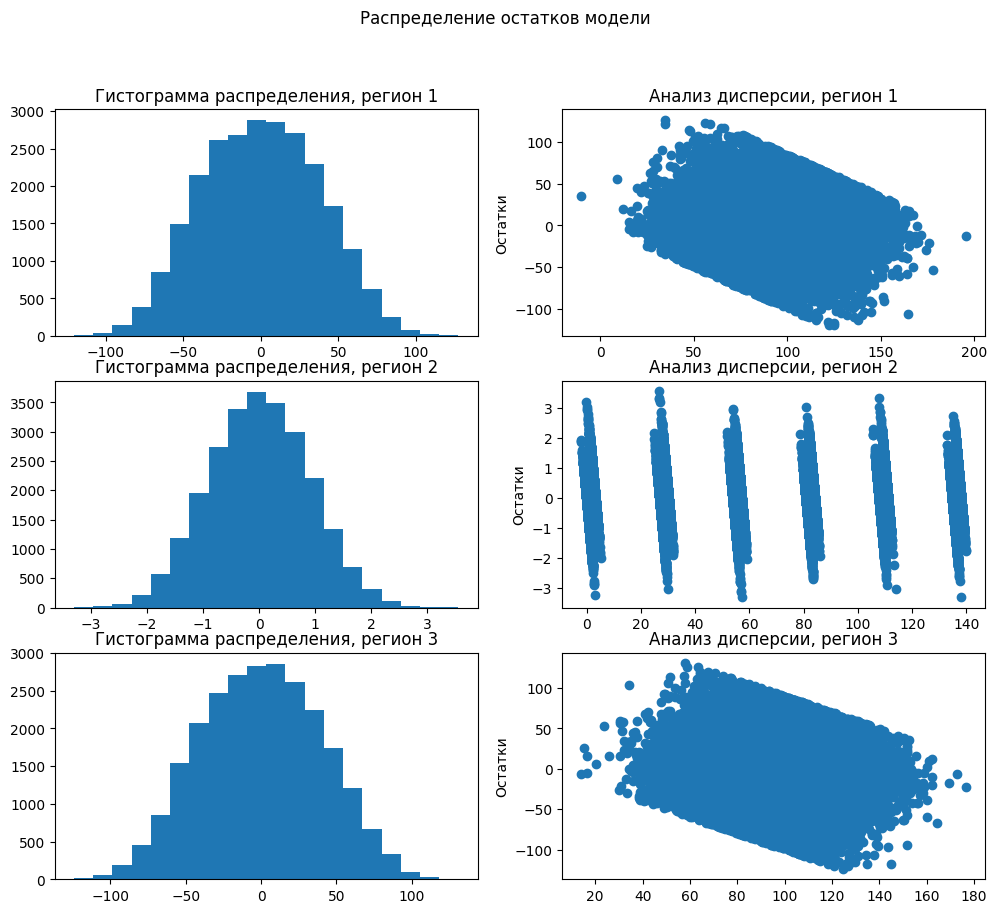

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
plt.suptitle('Распределение остатков модели')
for i in range(0,3):
    residuals = y_valid_pred_arr[i]['y_true']- y_valid_pred_arr[i]['y_pred']
    axes[i, 0].hist(x=residuals, bins=20)
    axes[i, 0].set_title('Гистограмма распределения, регион '+ str(i+1))
     
    axes[i, 1].scatter(x=y_valid_pred_arr[i]['y_pred'], y=residuals)
    axes[i, 1].set_ylabel('Остатки')
    axes[i, 1].set_title('Анализ дисперсии, регион '+ str(i+1))
plt.show()

**Вывод: анализ распределения остатков: остатки распределены симметрично, распределение по форме близко к нормальному, заметных выбросов нет. Анализ дисперсии показывает, что данные обладают более-менее  свойством гомоскедастичности (дисперсия более-менее постоянна вдоль прямой). Второй регион в смысле дисперсии подкачал, но это может быть связано со сбоем оборудования, что собирало данные и может быть устранено в будущем.**

## 3. Подготовка к расчёту прибыли

In [14]:
#цена 1000 баррелей
ONE_THOUSAND_PRODUCT_PRICE= 450000
#бюджет на разработку скважин в регионе
TOTAL_PRODUCT_COST= 10000000000
#достаточный объём сырья для безубыточной разработки новых скважин в регионе (в тыс.баррелей)
breakeven_total= TOTAL_PRODUCT_COST/ONE_THOUSAND_PRODUCT_PRICE

#количество лучших точек для разработки в каждом регионе
PLANNED_WELLS_COUNT=200

#достаточный объём сырья для безубыточной разработки одной скважины в регионе (в тыс.баррелей)
breakeven_one_well= breakeven_total/PLANNED_WELLS_COUNT
print(f'Достаточный объём сырья для безубыточной разработки одной скважины в регионе: {round(breakeven_one_well,1)} тыс.баррелей')

for i in range(0,3):
    #средний объем сырья в на 1 скважину в регионе согласно предсказаниям модели
    print(f'Средний запас сырья на одну скважину в {i+1} регионе: {round(y_valid_pred_arr[i]["y_pred"].mean(),1)} тыс.баррелей')

Достаточный объём сырья для безубыточной разработки одной скважины в регионе: 111.1 тыс.баррелей
Средний запас сырья на одну скважину в 1 регионе: 92.4 тыс.баррелей
Средний запас сырья на одну скважину в 2 регионе: 68.9 тыс.баррелей
Средний запас сырья на одну скважину в 3 регионе: 94.8 тыс.баррелей


**Вывод: достаточный объем сырья для безубыточной разработки одной скважины в регионе превышает средний запас сырья по регионам. Поэтому требуется выбирать лучшие из скважин, чтобы получить прибыль, а не убыток**

## 4. Расчет прибыли

In [15]:
#Выбор скважин с максимальными значениями предсказаний и расчет прибыли
def profit(true_volumes, predicted_volumes):
    #сбросим индекс, чтобы избавиться от повторений (в итоге- лишних записей при расчете суммы) при выборке лучших скважин
    true_volumes = true_volumes.reset_index(drop=True)
    predicted_volumes = predicted_volumes.reset_index(drop=True)

    sorted_predicted_volumes = predicted_volumes.sort_values(ascending=False)[:PLANNED_WELLS_COUNT]
    selected_true_volumes= true_volumes[sorted_predicted_volumes.index]
    #смуммарный доход для выбранных скважин
    total_income= ONE_THOUSAND_PRODUCT_PRICE * selected_true_volumes.sum()
    #расчет прибыли
    return (total_income- TOTAL_PRODUCT_COST)

## 5. Расчет рисков и прибыли для каждого региона

In [16]:
state = RandomState(12345) 
#количество исследуемых точек для разработки в каждом регионе
INVESTIGATED_WELLS_COUNT=500
max_profit=-1
best_region_index=-1
risk_threshold=2.5
best_region_risk=-1
best_region_confidence_interval_str=''
for j in range(0, 3):
    values = []
    for i in range(1000):
        target_subsample = y_valid_pred_arr[j]['y_true'].sample(n=INVESTIGATED_WELLS_COUNT, replace=True, random_state=state)
        pred_subsample = y_valid_pred_arr[j]['y_pred'][target_subsample.index] 
        rev= profit(target_subsample, pred_subsample)
        values.append(rev)

    values_sr= pd.Series(values)
    mean_profit_millions = values_sr.mean()/1000000
            
    print(f'Средняя прибыль для {j+1} региона: {round(mean_profit_millions,1)} млн.руб.')
    confidence_interval_str= f'({round(values_sr.quantile(0.025)/1000000, 2)}, {round(values_sr.quantile(0.975)/1000000, 2)})'
    print('95%-ый доверительный интервал:'+ confidence_interval_str)
    risk_of_losses= 100*(values_sr < 0).mean()
    print(f'Риск убытков: {round(risk_of_losses,2)}%')
    if risk_of_losses<risk_threshold:
        print(f'Риск убытков в регионе не превышает порогового значения {risk_threshold}, оставляем регион для дальнейшего рассмотрения')
    else: 
        print(f'Риск убытков в регионе превышает пороговое значение {risk_threshold}, более не рассматриваем данный регион')
    if mean_profit_millions>max_profit:
        max_profit=mean_profit_millions
        best_region_index=j
        best_region_risk=risk_of_losses
        best_region_confidence_interval_str=confidence_interval_str

print('')
if best_region_risk<risk_threshold:
    print(f'Регион с максимальной прибылью: {best_region_index+1}')
    print(f'Прогнозируемое значение прибыли: {round(max_profit,1)} млн.руб.')
    print('95%-ый доверительный интервал:'+ best_region_confidence_interval_str)
else: 
    print(f'Не удалось выбрать регион с максимальной прибылью - риск убытков превышает пороговое значение')


Средняя прибыль для 1 региона: 390.5 млн.руб.
95%-ый доверительный интервал:(-146.22, 918.18)
Риск убытков: 6.8%
Риск убытков в регионе превышает пороговое значение 2.5, более не рассматриваем данный регион
Средняя прибыль для 2 региона: 461.3 млн.руб.
95%-ый доверительный интервал:(78.9, 858.0)
Риск убытков: 0.6%
Риск убытков в регионе не превышает порогового значения 2.5, оставляем регион для дальнейшего рассмотрения
Средняя прибыль для 3 региона: 397.3 млн.руб.
95%-ый доверительный интервал:(-131.77, 930.57)
Риск убытков: 7.5%
Риск убытков в регионе превышает пороговое значение 2.5, более не рассматриваем данный регион

Регион с максимальной прибылью: 2
Прогнозируемое значение прибыли: 461.3 млн.руб.
95%-ый доверительный интервал:(78.9, 858.0)


## Общий вывод

**По результатам моделирования первый и третий регион не подходят для разработки из-за слишком большого риска получения убытков, при этом в любом случае наибольшую прибыль имеет второй регион. Однако похоже, что при сборе данных для анализа оборудованием были допущены ошибки так как данные имеют дискретный характер (а по сути должны быть непрерывными). Поэтому результаты моделирования стоит перепроверить после устранения ошибок.**